In [1]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot, spin_system_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator

import optimization
import spectra_processing

import save_procedures

reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(optimization.interactions)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(utils)

reload(mesher)
reload(mesher.delanay_neigbour)
reload(mesher.general_mesh)

reload(mesher.torch_tps)
from mesher.torch_tps import thin_plate_spline, polynomial_transform

reload(thin_plate_spline)
reload(polynomial_transform)
reload(mesher.torch_tps)

reload(spin_system_plot)
reload(save_procedures)

Some stuff might fail: issue in joblib
[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [2]:
g_tensor_1 = spin_system.Interaction((2.02, 2.12, 2.22))
g_tensor_2 = spin_system.Interaction((2.12, 2.20, 2.01))
freq = torch.tensor(9.81*1e9)

J = spin_system.DEInteraction([-700000*1e6, 20000*1e6])
base_spin_system = spin_system.SpinSystem(electrons=[1.0], g_tensors = [g_tensor_1], electron_electron=[(0, 0, J)])

sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e7, mesh=mesher.DelaunayMeshNeighbour(initial_grid_frequency=25, interpolation_grid_frequency=35, interpolate=False))
spect_creator = spectra_manager.StationarySpectraCreator(freq=freq, sample=sample)

fields = torch.linspace(0.31, 0.35, 3000)
g_factors = freq * constants.PLANCK / (fields * constants.BOHR)

spec_1_clean = spect_creator(sample, fields)

In [3]:
constants.unit_converter(1, "cm-1_to_Hz") / 1e10

2.99792458

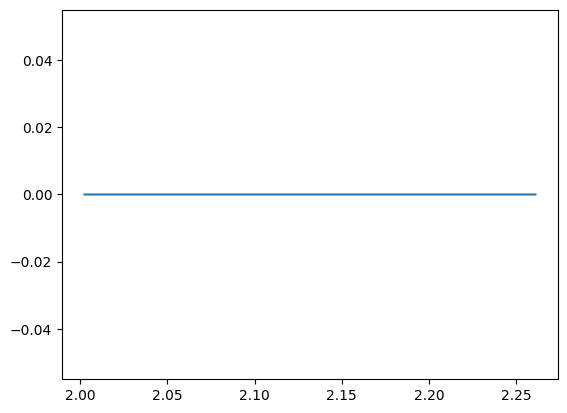

In [4]:
plt.plot(g_factors.numpy(), spec_1_clean.numpy())
#plt.savefig("spectra_example_3_clean.eps")
plt.show()

In [5]:
base_spin_system = spin_system.SpinSystem(electrons=[0.5, 0.5], g_tensors = [g_tensor_1, g_tensor_2], electron_electron=[(0, 1, J)])

In [6]:
sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e7, mesh=mesher.DelaunayMeshNeighbour(initial_grid_frequency=100, interpolation_grid_frequency=100, interpolate=False))

In [8]:
sample = sample.to(torch.float64)
spect_creator = spect_creator.to(torch.float64)

spec_1_clean = spect_creator(sample, fields)

In [7]:
g_tensor_1 = spin_system.Interaction((2.12, 2.02, 2.02))
g_tensor_2 = spin_system.Interaction((2.02, 2.02, 2.12))
freq = torch.tensor(9.81*1e9)

J = spin_system.Interaction(constants.unit_converter(0.1, "cm-1_to_Hz")) + spin_system.DEInteraction([70*1e6, 4*1e6])
base_spin_system = spin_system.SpinSystem(electrons=[0.5, 0.5], g_tensors = [g_tensor_1, g_tensor_2], electron_electron=[(0, 1, J)])

sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e7, mesh=mesher.DelaunayMeshNeighbour(initial_grid_frequency=100, interpolation_grid_frequency=100, interpolate=False))
spect_creator = spectra_manager.StationarySpectraCreator(freq=freq, sample=sample)

fields = torch.linspace(0.31, 0.35, 3000)
g_factors = freq * constants.PLANCK / (fields * constants.BOHR)

spec_1_clean = spect_creator(sample, fields)

In [62]:
spec_1_noized = spec_1_clean + torch.rand_like(spec_1_clean) * 0.01 - 0.5 * fields + 0.5 * 10 * (fields - 0.3)**2

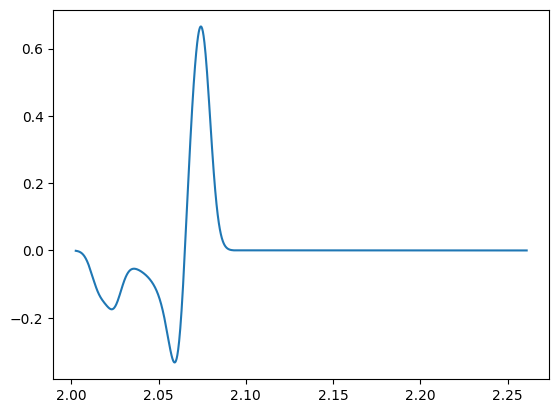

In [63]:
plt.plot(g_factors.numpy(), spec_1_clean.numpy())
#plt.savefig("spectra_example_3_clean.eps")
plt.show()

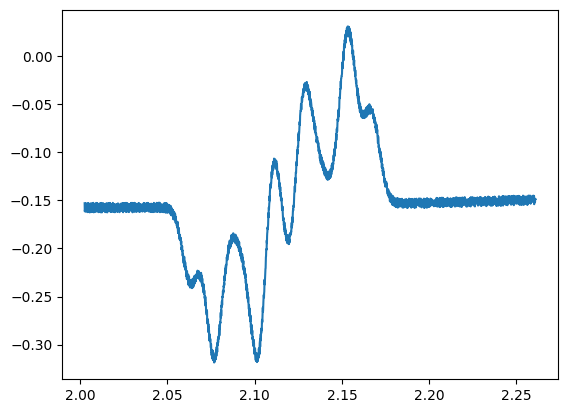

In [6]:
plt.plot(g_factors.numpy(), spec_1_noized.numpy())
plt.savefig("spectra_example_3_noized.eps")
plt.show()

#### BUG

In [12]:
import res_field_algorithm

reload(res_field_algorithm)
reload(mesher)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [94]:
mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=35, interpolation_grid_frequency=100, dtype=torch.float64)

In [95]:
mesh.rotation_matrices.dtype

torch.float64

In [110]:
e_1 = particles.Electron(spin=1.5)
g_1 = spin_system.Interaction((2.1, 2.1, 2.1), dtype=torch.float64)

D = 100000 * 1e6
E = 1e3 * 1e6

zer = spin_system.DEInteraction((D, E), dtype=torch.float64)

mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=30, interpolation_grid_frequency=60, dtype=torch.float64)
system = spin_system.SpinSystem([e_1, ], g_tensors=(g_1,), electron_electron=[(0, 0, zer)], dtype=torch.float64)
sample = spin_system.MultiOrientedSample(system, ham_strain=(2e9, 2e9, 2e9), lorentz=0.01, gauss=0.01, mesh=mesh, dtype=torch.float64)

fields_1 = torch.linspace(0.0, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 3.5
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=torch.float64)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

In [112]:
constants.unit_converter(E, "Hz_to_cm-1")

0.03335640951981521

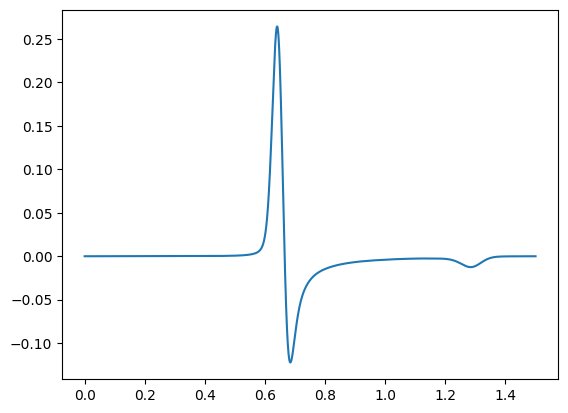

In [113]:
plt.plot(fields_1.numpy(), spec_1.numpy())

In [114]:
import pandas as pd

data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

In [22]:
dtype = torch.float64

In [118]:
mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=50, interpolation_grid_frequency=100, dtype=torch.float64)

e_1 = particles.Electron(spin=0.5)
e_2 = particles.Electron(spin=1.5)
g_1 = spin_system.Interaction((2.1, 2.2, 2.3), dtype=dtype)
g_2 = spin_system.Interaction((2.1, 2.1, 2.1), dtype=dtype)

J = constants.unit_converter(0, "cm-1_to_Hz")
D = 1000 * 1e6
E = 0.0

ee = spin_system.Interaction(J, dtype=dtype) + spin_system.DEInteraction((D, E), dtype=dtype)
zer = spin_system.DEInteraction((D, E), dtype=dtype)


system = spin_system.SpinSystem([e_1, e_2], g_tensors=(g_1, g_2), electron_electron=[(0, 1, ee), (1, 1, zer)], dtype=dtype)
sample = spin_system.MultiOrientedSample(system, ham_strain=(2e8, 2e8, 2e8), lorentz=0.01, gauss=0.01, dtype=dtype)

fields_1 = torch.linspace(1.1, 1.4, 3000)
freq = torch.tensor(38 * 1e9)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, mesh=mesh, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

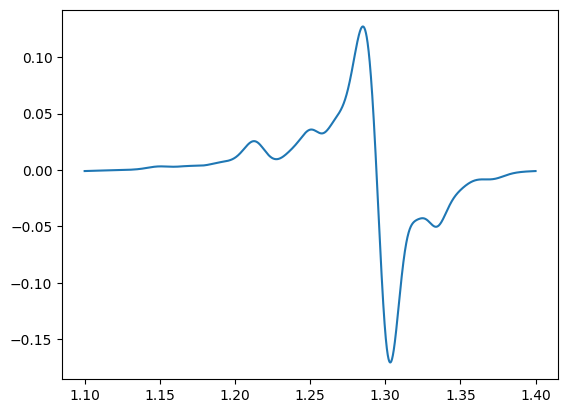

In [119]:
plt.plot(fields_1.numpy(), spec_1.numpy())

In [120]:
import pandas as pd

data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")


In [24]:
param_space = optimization.SampleVary().vary(sample,
                               g_tensors=(
                                   (0, optimization.VaryInteraction((0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1))),
                               )
                              )

In [121]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, orient_up)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        J = J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        J = torch.full((3,), J)
        d_frame = torch.zeros(3)
        ee_int_chain = spin_system.Interaction(J, d_frame)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([1e9, 1e9, 1e9]), gauss, lorentz, mesh)

In [ ]:
orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)


J = -0.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.2, 2.2, 2.2]
gauss = torch.tensor(0.0001)
lorentz = torch.tensor(0.01)
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=30,
                                    interpolate=True, interpolation_grid_frequency=60)


system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)


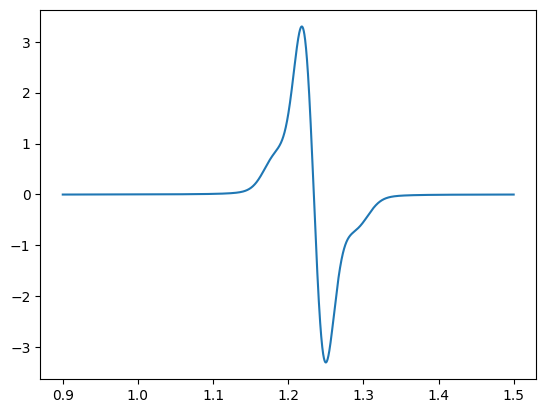

In [123]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [120]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

### dipole-dipole

In [64]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=15,
                                    interpolate=False, interpolation_grid_frequency=70)

def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.003, "cm-1_to_Hz")
        J = J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        ee_int_chain = spin_system.Interaction(J) + spin_system.DEInteraction((D, E))
        print(ee_int_chain)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([5e7, 5e7, 5e7]), gauss, lorentz, mesh)

In [65]:
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

Principal values: [-9.09e+08, -1.09e+09, 2.00e+09]
Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
Strain: None


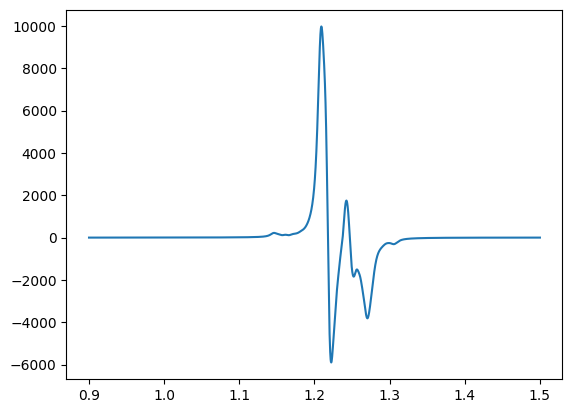

In [66]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

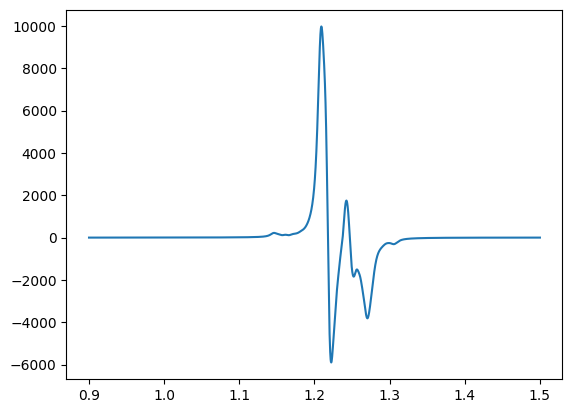

In [67]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [68]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

(0, 1)


### D-E interaction

In [3]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [67]:
constants.unit_converter(3, "cm-1_to_Hz") / (1e6 * 1e5)

0.899377374

In [65]:
constants.unit_converter(0.03, "cm-1_to_Hz") / (1e6 * 1e3)

0.899377374

In [10]:
dtype = torch.float64

In [11]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain, dtype=dtype)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, frame=torch.tensor([1.0, 1.0, 1.0]), dtype=dtype)
        
        g_cu_branching = torch.tensor(g_cu_branching, dtype=dtype)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, dtype=dtype)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.0, "cm-1_to_Hz")

        ee_int_chain = spin_system.DEInteraction((D, E))
        ee_int_exchange = spin_system.Interaction(-2*constants.unit_converter(J, "cm-1_to_Hz"),)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 0, ee_int_chain), (0, 1, ee_int_exchange)
            ], dtype=dtype
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0.0, 0.0, 0.0], dtype=dtype), gauss, lorentz, mesh, dtype=dtype)

In [12]:
dtype = torch.float64
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=45,
                                    interpolate=True, interpolation_grid_frequency=90, dtype=dtype)

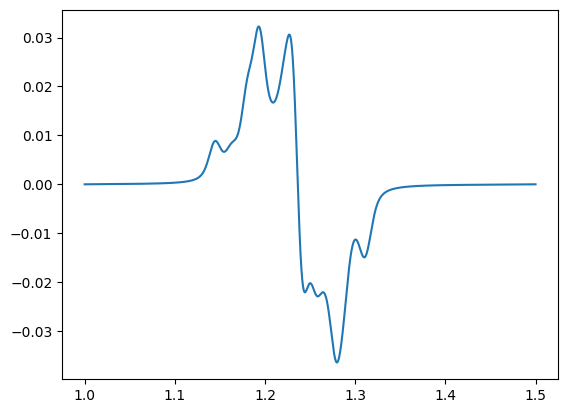

In [13]:
J = -5.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.1, 2.2, 2.3]
gauss = torch.tensor(0.01)
lorentz = torch.tensor(0.01)

system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.0, 1.50, 3000, dtype=dtype)
freq = torch.tensor(38 * 1e9, dtype=dtype)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

## SYSTEM WITH BUG. WORK CORRECT ONLY at r_tol == 1e-9

In [21]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [19]:
constants.unit_converter(3, "cm-1_to_Hz") / (1e6*1e3)

89.9377374

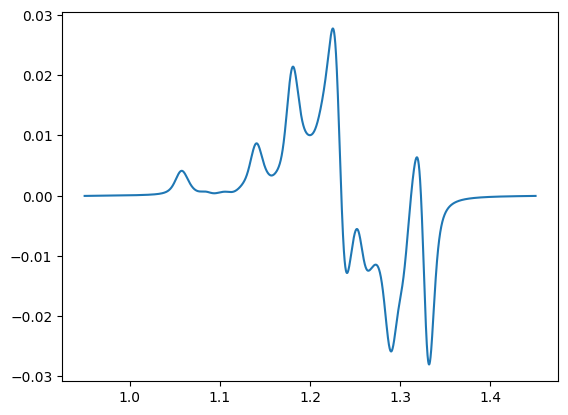

In [59]:
dtype = torch.float64
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=45,
                                    interpolate=True, interpolation_grid_frequency=90, dtype=dtype)

def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain, dtype=dtype)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, frame=torch.tensor([0.0, 0.0, 0.0]), dtype=dtype)
        
        g_cu_branching = torch.tensor(g_cu_branching, dtype=dtype)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, dtype=dtype)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.2, "cm-1_to_Hz"), constants.unit_converter(0.03, "cm-1_to_Hz")

        ee_int_chain = spin_system.DEInteraction((D, E))
        ee_int_exchange = spin_system.Interaction(-2*constants.unit_converter(J, "cm-1_to_Hz"),)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 0, ee_int_chain), (0, 1, ee_int_exchange)
            ], dtype=dtype
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0, 0, 0], dtype=dtype), gauss, lorentz, mesh, dtype=dtype)

J = -3.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.1, 2.2, 2.3]
gauss = torch.tensor(0.01)
lorentz = torch.tensor(0.01)

system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(0.95, 1.45, 6000, dtype=dtype)
freq = torch.tensor(38 * 1e9, dtype=dtype)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

## END SYSTEM WITH BUG

In [137]:
dtype = torch.float64

g_tensor_1 = spin_system.Interaction((2.12, 2.02, 2.30), dtype=dtype)
freq = torch.tensor(9.81*1e9, dtype=dtype)
mesh=mesher.DelaunayMeshNeighbour(initial_grid_frequency=100, interpolation_grid_frequency=100, interpolate=False, dtype=dtype)


base_spin_system = spin_system.SpinSystem(electrons=[0.5], g_tensors = [g_tensor_1], dtype=dtype)

sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=torch.tensor([1e8, 1e8, 1e9], dtype=dtype), dtype=dtype, mesh=mesh)
spect_creator = spectra_manager.StationarySpectraCreator(freq=freq, sample=sample, dtype=dtype)

fields = torch.linspace(0.2, 0.45, 3000, dtype=dtype)
spec = spect_creator(sample, fields)

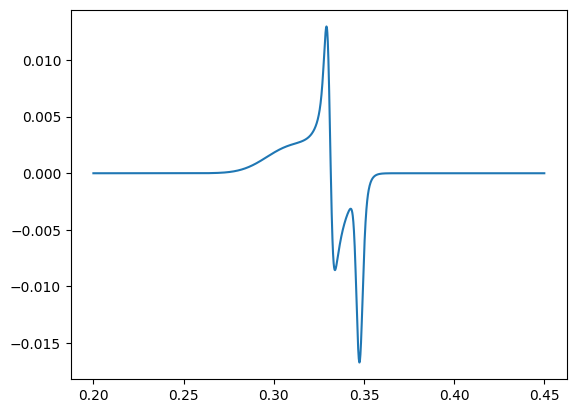

In [138]:
plt.plot(fields.numpy(), spec.numpy())

## END BUG

In [139]:
import pandas as pd
fields = fields.numpy()
spec = spec.numpy()


data_frame = pd.DataFrame({"field": fields, "spec": spec})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spect_creator, fields, format_type="easyspin")

0


### Nuclei

In [22]:
dtype = torch.float64

In [26]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain, dtype=dtype)
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, dtype=dtype)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, dtype=dtype)
        
        g_cu_branching = torch.tensor(g_cu_branching, dtype=dtype)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, dtype=dtype)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        A_interaction = spin_system.Interaction((1e7, 1e7, 1e9), dtype=dtype)

        
        system = spin_system.SpinSystem(
            electrons=[e_chain],
            nuclei = ["14N", "14N"],
            g_tensors=[zeem_chain],
            electron_nuclei=[(0, 0, A_interaction), (0, 1, A_interaction)], dtype=dtype
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0.0, 0.0, 0.0]), gauss, lorentz, mesh, dtype=dtype)

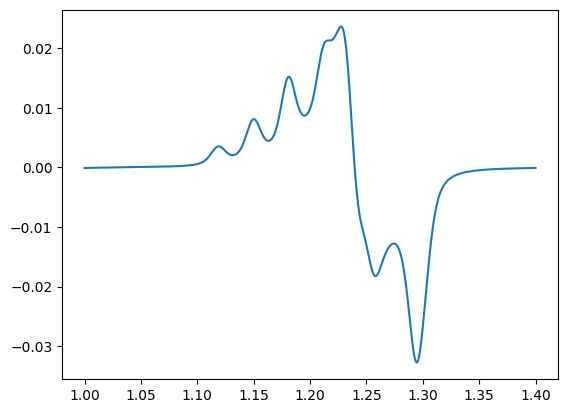

In [30]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=45, 
                                    interpolate=True, interpolation_grid_frequency=100, dtype=dtype)
orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)


J = -0.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.2, 2.2, 2.2]
gauss = torch.tensor(0.01)
lorentz = torch.tensor(0.01)
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.0, 1.40, 3000)
freq = torch.tensor(38 * 1e9)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [29]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [24]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [139]:
out = save_procedures.load("D:\ITC\РНФ_Курганский_2024\example.mat", format_type="easyspin")

In [140]:
sample = out["sample"]

In [142]:
print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=1.0 
Principal values: [2.1000, 2.2000, 2.3000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  e1: S=0.5 
Principal values: [2.2000, 2.2000, 2.2000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None

Nuclei (2):
  n0: I=1.0
  n1: I=1.0

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 54
Configuration shape: ()

INTERACTIONS (5 total):
------------------------------

Electron-Nucleus (4):
  1. e0 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  2. e0 ↔ n1:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  3. e1 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  4. e1 ↔

In [4]:
dtype = torch.float64

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=15, 
                                    interpolate=True, interpolation_grid_frequency=20, dtype=dtype)

g_tensor = spin_system.Interaction((2.12, 2.12, 2.12), dtype=dtype)
A_tensor = spin_system.Interaction(285*1e6, dtype=dtype)

ZFS = spin_system.DEInteraction([2230*1e6, 0.0*1e6])
base_spin_system = spin_system.SpinSystem(
    electrons=[5/2], nuclei=["55Mn"], g_tensors = [g_tensor], electron_electron=[(0, 0, ZFS)], electron_nuclei=[(0, 0, A_tensor)], dtype=dtype
)


freq = torch.tensor(9.5 * 1e9)
temp = 3.5
sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e9, mesh=mesh, dtype=dtype)
fields = torch.linspace(0.0, 1.0, 2000)
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype, harmonic=0)

with torch.no_grad():
    spec = spec_creat(sample, fields)

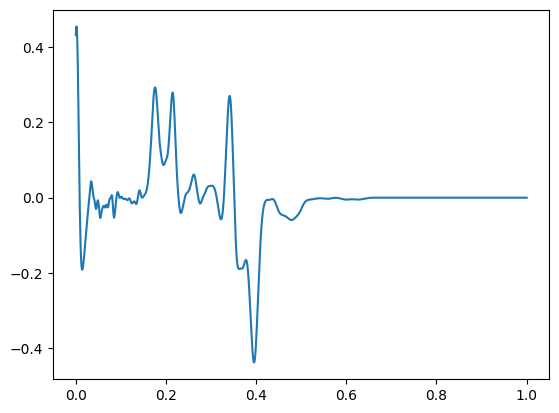

In [3]:
plt.plot(fields.numpy(), spec.numpy())